In [112]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy


%matplotlib inline


In [160]:
conn = psycopg2.connect("""
    host=rc1c-5lsfxv5qer0uol30.mdb.yandexcloud.net
    port=6432
    dbname=olist
    user=user1
    password=olistolist
    target_session_attrs=read-write
    sslmode=verify-full
""") 

In [69]:
conn.status

1

In [70]:
pd.read_sql('''SELECT table_name FROM information_schema.tables WHERE table_schema='public' '''
           ,conn)

,table_name
0,closed_deals
1,customers
2,geolocation
3,marketing_qualified_leads
4,order_items
5,order_payments
6,order_reviews
7,orders
8,products
9,sellers


Можно ли при анализе оценок и отзывов полагаться только на данные as is? Есть ли какие-то особенности в том как клиенты дают обратную связь, которые надо принять во внимание? Если да, какие есть способы, чтобы их учесть?

In [16]:
tmp = pd.read_sql('''SELECT review_score, count(*)  / sum(count(*)) over() as percent_of_score
                    FROM olist.public.order_reviews
                    group by review_score 
                    order by review_score'''
                  ,conn)
tmp

,review_score,percent_of_score
0,1,0.115133
1,2,0.031756
2,3,0.082430
3,4,0.192917
4,5,0.577763


Хм... Так я был абсолютно не прав. Получается, что оценки наоборот смещены в положительную сторону. 
И это необходимо учитывать. 
Как? Все зависит от задачи. Первые два которые приходят в голову:
1. Сбалансировать классы. Например убрать у товаров с большим кол-вом положительных отзывов эти отзывы. И сбалансировать оценки
2. Объединить все в 2 класса 1-4 и 5.


In [86]:
''' 
Здесь объяснение невозможности выполнения этого задания. 
Отзывы и оценки из таблицы order_reviews выставляются 
по order_id. А проблема заключается в том, что в 
таблице order_items на один order_id приходится несколько 
товаров. И какому конкретному товару относится тот или иной отзыв
 - не очевидно. Т.е. мы не знаем к какому товару относится та или иная 
 оценка. 
 Или я не правильно понял составляющую таблиц
'''

pd.read_sql('''SELECT order_id, count(product_id) as count_uniq_item
                    FROM olist.public.order_items
                    group by order_id
                having count(product_id) >=2
                limit 10'''
                  ,conn)

,order_id,count_uniq_item
0,283548b206a96af4094495858774befe,3
1,34b3d6f518fb789c443e4ec00f9bb0ce,5
2,06d9e69034388abf6da64378e10737b8,2
3,01a4ec962d7589584c11650ca20d728b,2
4,29e438b97b6d677fa72eeb836259ac4d,2
5,176ada94dcc6f5fa6091d19a9d1fffde,2
6,05c7aa3928dd1b25667ba59cdc277505,2
7,024554aeb0da84476f1c31a711e0990c,2
8,05bfcf9e287cad216cadb8a850f8db5c,2
9,1d432ff6ecb6a501752815ce48038a89,2


In [99]:
#Каково распределение отзывов? По пользователям, по регионам, по товарам, продавцам?
#Надо построить просто график с выпадающим списками. Была бы BI...

'''
Это пример того, как я бы выполнял задание.
#frame - как-будто бы join таблички 

order_items
order_reviews
orders
inner по order_id

customers 
left по customer_id (c доп проверкой на повтор строк)
'''



frame = pd.DataFrame(np.random.randint(1,6,size=(10000, 5)),
                     columns=['user','region',
                              'item','saler', 
                              'score'])

def print_plot(user=None, region=None,
               item=None, saler=None):
    '''
    Функция возвращает гистограмму распределения оценок.

            Parameters:
                    table : таблица с данными
                    user : код пользователя
                    region : код региона
                    item : код товара
                    saler : код продавца

            Returns:
                    binary_sum (str): Binary string of the sum of a and b
    '''
    # Я знаю, что использование объектов внутри функции из вне
    # очень плохо. Но, иначе, у меня не работал интерактивный график. 
    tmp = (frame[(frame['user'].map(lambda x: x==user 
                                    if user!=None 
                                    else x in frame['user']))&
                 (frame['region'].map(lambda x: x==region 
                                    if user!=None 
                                    else x in frame['region']))&
                 (frame['item'].map(lambda x: x==item 
                                    if user!=None 
                                    else x in frame['item']))&
                 (frame['saler'].map(lambda x: x==saler 
                                    if user!=None 
                                    else x in frame['saler']))])
    plt.hist(tmp['score'], bins=tmp['score'].nunique())
    plt.title(f'''Распределение_оценок
                 _{user}_{region}
                 _{item}_{saler}''')
    
 
    
    
users = frame['user'].unique()
regions = frame['region'].unique()
items = frame['item'].unique()
salers = frame['saler'].unique()


interact(print_plot, user=users, region=regions,
         item=items, saler=salers)

# Не очень понял почему, но выбирать значения лучше из списка снизу, иначе вылетает ошибка
# Юзая эту либу первый раз. 

interactive(children=(Dropdown(description='user', options=(5, 2, 3, 4, 1), value=None), Dropdown(description=…

<function __main__.print_plot(user=None, region=None, item=None, saler=None)>

Так как мы не можем понять какому именно товару поставлена какая оценка, то я бы запросил доп данные по оценке items.

Есть ли связь между оценками и продажами? Например, оцените вероятность возвращения клиента после высокой оценки и после низкой. Что будет со средним чеком?

In [106]:
sql = f''' 
select t1.order_id, t1.customer_id
, date(t1.order_purchase_timestamp) as date_of_order
, t2.review_score
, row_number() over (partition by  t1.customer_id 
                     order by t1.customer_id, 
                     t1.order_purchase_timestamp) as num_of_order 
from orders as t1
inner join order_reviews as t2 
on t1.order_id = t2.order_id
'''

frame = pd.read_sql(sql, conn)
frame.head()

,order_id,customer_id,date_of_order,review_score,num_of_order
0,5f79b5b0931d63f1a42989eb65b9da6e,00012a2ce6f8dcda20d059ce98491703,2017-11-14,1,1
1,a44895d095d7e0702b6a162fa2dbeced,000161a058600d5901f007fab4c27140,2017-07-16,4,1
2,316a104623542e4d75189bb372bc5f8d,0001fd6190edaaf884bcaf3d49edf079,2017-02-28,5,1
3,5825ce2e88d5346438686b0bba99e5ee,0002414f95344307404f0ace7a26f1d5,2017-08-16,5,1
4,0ab7fb08086d4af9141453c91878ed7a,000379cdec625522490c315e70c7a9fb,2018-04-02,4,1


Так, как будем проверять. 
Посмтрим, как выглядело распределние оценок для 
пользователей, которые заказывали только 1 раз и для пользователей, которые заказывали больше 1 раза. 
Я ожидаю увидеть, что оценки для второй выборки пользователей будут "более положительные". 

In [119]:
users_list_more_orders = (frame['customer_id']
                          [frame['num_of_order']>=2].unique())
score_1_order = (frame['review_score']
                 [(~frame['customer_id'].isin(users_list_more_orders))&
                  (frame['num_of_order']==1)])
score_more_order = (frame['review_score']
                 [(frame['customer_id'].isin(users_list_more_orders))&
                  (frame['num_of_order']==1)])

stat, p =  scipy.stats.mannwhitneyu(score_1_order, score_more_order)
print('p_value: ', p)
alpha = 0.05
if p > alpha:
    print('Выборки принадлежат одной генеральной совокупности')
else:
    print('''Не можем опровергнуть гипотезу о принадлежности 
             к одной генеральной совокупности''')

p_value:  0.29303453699094695
Выборки принадлежат одной генеральной совокупности


К сожалению, данная гипотеза не подтвердилась. Не получилось опровергнуть гипотезу о том, что пользователи, которые совершали больше одной покупки ставили другие оценки после первой покупки. 

Если бы разница была обнаружена, то можно было бы посмотреть на воронку по покупкам(это некий аналог воронки в играх). Какова вероятность след покупки в зависимости от оценки. 

Есть ли связь оценок и сроков доставки заказов?

In [128]:
frame = pd.read_sql(''' Select t1.order_id, 
                        EXTRACT(EPOCH FROM (order_delivered_customer_date
                        - order_purchase_timestamp)) AS delivery_time  
                        ,t2.review_score
                from orders as t1
                inner join order_reviews as t2
                on t1.order_id = t2.order_id
                ''', conn)
frame.head()

,order_id,delivery_time,review_score
0,8e6bfb81e283fa7e4f11123a3fb894f1,1575272.0,5
1,b18dcdf73be66366873cd26c5724d1dc,500339.0,1
2,e48aa0d2dcec3a2e87348811bcfdf22b,1286318.0,5
3,c31a859e34e3adac22f376954e19b39d,500159.0,5
4,0ce9a24111d850192a933fcaab6fbad3,1637276.0,1


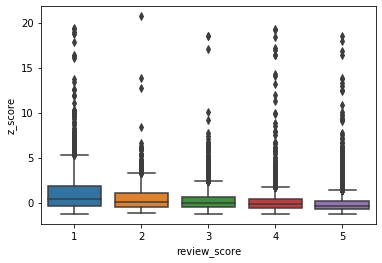

In [134]:
sns.boxplot(data=frame, x='review_score', y='z_score')

In [155]:

def q75(x):
    return x.quantile(0.75)

def q25(x):
    return x.quantile(0.25)

tmp_pivot = frame.pivot_table(index='review_score',
                              values='delivery_time',
                              aggfunc=['mean', 
                                       q25,
                                       q75]).reset_index()
tmp_pivot.columns = tmp_pivot.columns.droplevel(1)
tmp_pivot

,review_score,mean,q25,q75
0,1,1.841307e+06,797028.00,2635354.00
1,2,1.439474e+06,692202.00,1927859.00
2,3,1.232234e+06,659773.25,1597184.25
3,4,1.063788e+06,609369.00,1377249.50
4,5,9.234955e+05,532068.50,1197096.75


In [157]:
tmp = frame.merge(tmp_pivot, how='left', on='review_score')
tmp['board'] = tmp['q75'] + 1.5 * (tmp['q75'] - tmp['q25'])
(tmp[['delivery_time', 'review_score']]
 [tmp['delivery_time']<=tmp['board']].corr('spearman'))

,delivery_time,review_score
delivery_time,1.000000,-0.246432
review_score,-0.246432,1.000000


Связь присутствует, но она незначительна. В целом, можно сказать, что "долгость" доставки влияет на ухудшение оценки пользователем.

In [140]:
data = [frame['delivery_time'][(frame['review_score']==i)&
                               (frame['delivery_time']>0)] 
        for i in range(1,6)]
stat, p = scipy.stats.kruskal(data[0], data[1], data[2], data[3], data[4])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=6067.837, p=0.000
Different distributions (reject H0)


О чем пишут в отзывах? Какие характеристики товаров волнуют пользователей в первую очередь? Какая тональность преобладает? Можно ли по отзыву предсказать оценку? 

Так как в нашем мире существует GPT-3 то это задача как-бы решенная. Более того, некоторые облака позволяют делать что-то похожее. К сожалению, я использовал весь свой бесплатный ресурс на Azure( 
Я не большой мастер в NLP, но что-то может получиться. 

In [164]:
sql = f'''select  review_score, review_comment_message from order_reviews
          where  review_comment_message is not Null   '''

frame = pd.read_sql(sql, conn)

In [168]:
!pip install wordcloud

     |████████████████████████████████| 366 kB 2.2 MB/s eta 0:00:01


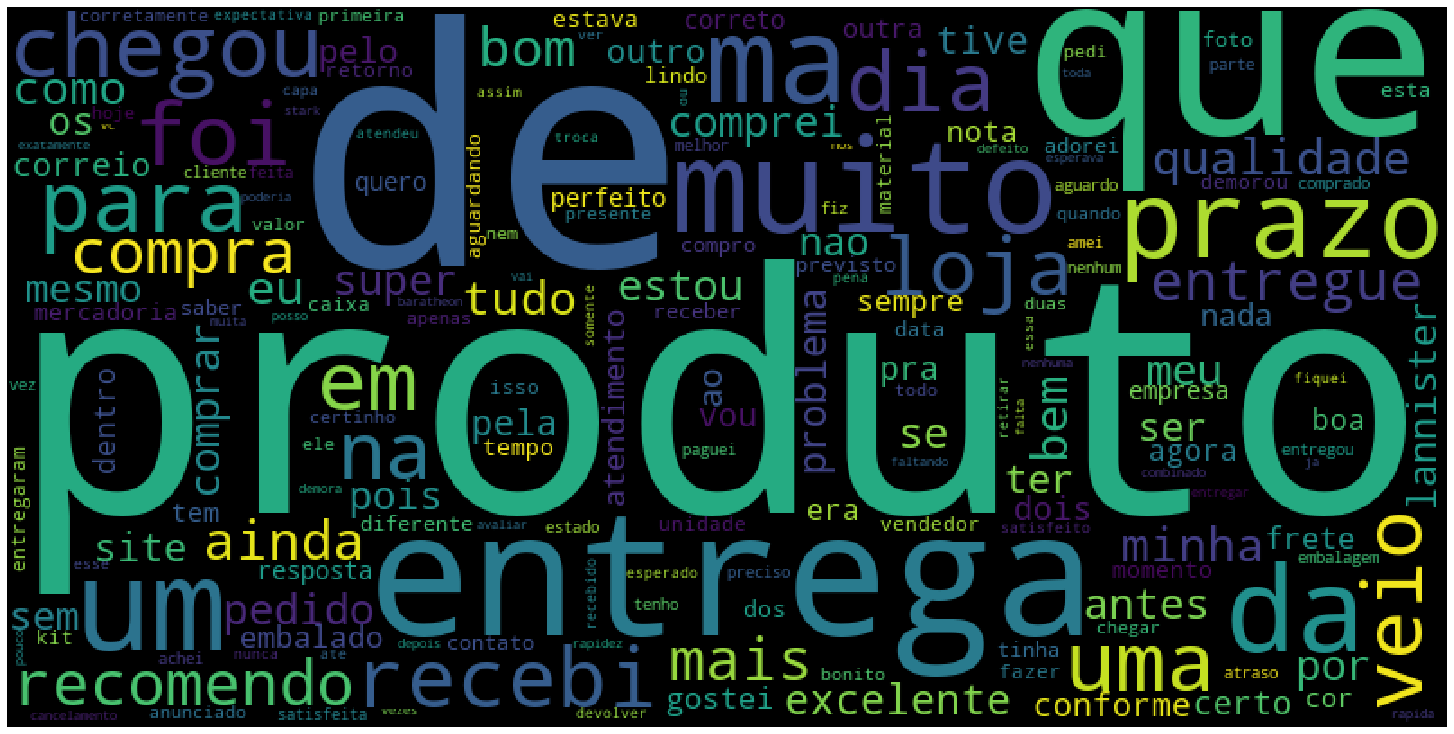

In [169]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud 
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                  
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                    
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)

cv_data = count_vectorizer.fit_transform(frame['review_comment_message'])
tfidf_data = tfidf_vectorizer.fit_transform(frame['review_comment_message'])

for_wordcloud = count_vectorizer.get_feature_names()
for_wordcloud = for_wordcloud
for_wordcloud_str = ' '.join(for_wordcloud)

wordcloud = WordCloud(width=800, height=400, background_color ='black',
                      min_font_size = 7).generate(for_wordcloud_str)

plt.figure(figsize=(20, 10), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
 
plt.show()